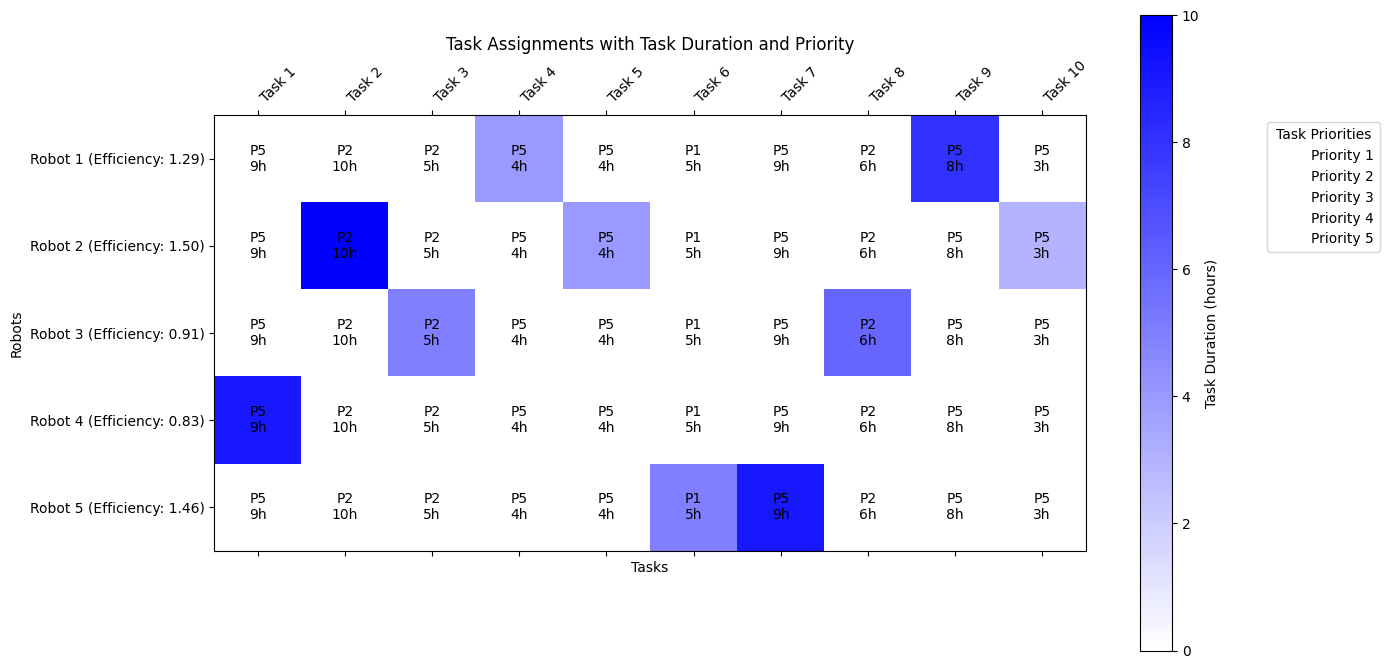

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Set random seed for reproducibility
np.random.seed(None)

# Function to generate mock data for tasks and robots
def generate_mock_data(num_tasks=10, num_robots=5):
    task_durations = np.random.randint(1, 11, size=num_tasks)  # Random task durations between 1 and 10 hours
    task_priorities = np.random.randint(1, 6, size=num_tasks)  # Random task priorities between 1 and 5
    robot_efficiencies = np.random.uniform(0.5, 1.5, size=num_robots)  # Random robot efficiencies between 0.5 and 1.5
    return task_durations, task_priorities, robot_efficiencies

# GA algorithm implementation
def run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies, population_size=50, n_generations=100):
    """
    Genetic Algorithm implementation to optimize task assignments.

    Parameters:
    - task_durations: Array of task durations
    - task_priorities: Array of task priorities
    - robot_efficiencies: Array of robot efficiencies
    - population_size: Size of the population
    - n_generations: Number of generations

    Returns:
    - best_solution: Best solution found by the GA
    """
    # Initialize population
    population = [np.random.randint(0, len(robot_efficiencies), size=len(task_durations)) for _ in range(population_size)]

    # Main GA loop
    for _ in range(n_generations):
        # Evaluate fitness of each individual in the population
        fitness_scores = [fitness_function(individual, task_durations, task_priorities, robot_efficiencies) for individual in population]

        # Select parents for crossover
        selected_parents = selection(population, fitness_scores)

        # Perform crossover to create offspring
        offspring_population = crossover(selected_parents)

        # Mutate offspring
        mutated_offspring_population = mutation(offspring_population)

        # Replace old population with offspring
        population = mutated_offspring_population

    # Select the best solution from the final population
    best_solution_index = np.argmin(fitness_scores)
    best_solution = population[best_solution_index]

    return best_solution

# Fitness function
def fitness_function(individual, task_durations, task_priorities, robot_efficiencies):
    """
    Calculate the fitness of an individual solution.

    Parameters:
    - individual: Array representing the assignment of tasks to robots
    - task_durations: Array of task durations
    - task_priorities: Array of task priorities
    - robot_efficiencies: Array of robot efficiencies

    Returns:
    - fitness_score: Fitness score of the individual solution
    """
    # Calculate total time taken by each robot
    robot_times = np.zeros(len(robot_efficiencies))
    for task, robot in enumerate(individual):
        robot_times[robot] += task_durations[task] / robot_efficiencies[robot]

    # Calculate total production time
    total_time = np.max(robot_times)

    # Compute workload balance
    balance = np.std(robot_times)

    # Prioritize critical tasks effectively
    priority_score = np.sum(task_priorities * (1 - np.exp(-task_durations / np.max(task_durations))))

    # Combine fitness components
    fitness_score = total_time + balance + priority_score

    return fitness_score

# Selection process
def selection(population, fitness_scores):
    """
    Select parents for crossover based on fitness scores.

    Parameters:
    - population: List of individuals
    - fitness_scores: List of fitness scores corresponding to each individual

    Returns:
    - selected_parents: List of selected parents for crossover
    """
    # Perform tournament selection
    tournament_size = 5
    selected_parents = []
    for _ in range(len(population)):
        tournament_indices = np.random.choice(len(population), size=tournament_size, replace=False)
        tournament_scores = [fitness_scores[i] for i in tournament_indices]
        selected_index = tournament_indices[np.argmin(tournament_scores)]
        selected_parents.append(population[selected_index])
    return selected_parents

# Crossover operation
def crossover(selected_parents):
    """
    Perform crossover to create offspring.

    Parameters:
    - selected_parents: List of selected parents for crossover

    Returns:
    - offspring_population: List of offspring solutions
    """
    # Perform single-point crossover
    crossover_rate = 0.8
    offspring_population = []
    for i in range(0, len(selected_parents), 2):
        parent1, parent2 = selected_parents[i], selected_parents[i + 1]
        if np.random.rand() < crossover_rate:
            crossover_point = np.random.randint(1, len(parent1))
            offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring_population.extend([offspring1, offspring2])
        else:
            offspring_population.extend([parent1, parent2])
    return offspring_population

# Mutation operation
def mutation(offspring_population):
    """
    Perform mutation on offspring.

    Parameters:
    - offspring_population: List of offspring solutions

    Returns:
    - mutated_offspring_population: List of mutated offspring solutions
    """
    # Perform random mutation
    mutation_rate = 0.1
    mutated_offspring_population = []
    for offspring in offspring_population:
        if np.random.rand() < mutation_rate:
            mutation_point = np.random.randint(len(offspring))
            mutated_value = np.random.randint(len(robot_efficiencies))
            offspring[mutation_point] = mutated_value
        mutated_offspring_population.append(offspring)
    return mutated_offspring_population

# Visualization function
def visualize_assignments_improved(solution, task_durations, task_priorities, robot_efficiencies):
    # Create a grid for visualization based on the solution provided
    grid = np.zeros((len(robot_efficiencies), len(task_durations)))
    for task_idx, robot_idx in enumerate(solution):
        grid[robot_idx, task_idx] = task_durations[task_idx]

    fig, ax = plt.subplots(figsize=(14, 7))  # Adjusted figure size

    # Display the grid with task durations
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "blue"])  # Custom colormap
    cax = ax.matshow(grid, cmap=cmap)

    # Annotate each cell with task priority and duration
    for i in range(len(robot_efficiencies)):
        for j in range(len(task_durations)):
            text = f"P{task_priorities[j]}\n{task_durations[j]}h"  # Updated annotations
            ax.text(j, i, text, ha='center', va='center', color='black')  # <-- Green color for commented lines

    # Set the ticks and labels for tasks and robots
    ax.set_xticks(np.arange(len(task_durations)))
    ax.set_yticks(np.arange(len(robot_efficiencies)))
    ax.set_xticklabels([f'Task {i+1}' for i in range(len(task_durations))], rotation=45, ha="left")
    ax.set_yticklabels([f'Robot {i+1} (Efficiency: {eff:.2f})' for i, eff in enumerate(robot_efficiencies)])

    plt.xlabel('Tasks')
    plt.ylabel('Robots')
    plt.title('Task Assignments with Task Duration and Priority')

    # Create a legend for task priorities
    priority_patches = [mpatches.Patch(color='white', label=f'Priority {i}') for i in range(1, 6)]
    plt.legend(handles=priority_patches, bbox_to_anchor=(1.20, 1), loc='upper left', title="Task Priorities")

    # Add color bar beside the chart
    plt.colorbar(cax, ax=ax, label='Task Duration (hours)')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    num_tasks = 10
    num_robots = 5
    task_durations, task_priorities, robot_efficiencies = generate_mock_data(num_tasks, num_robots)

    # Run GA to find the best solution
    best_solution = run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies)

    # Visualize the initial random assignment
    visualize_assignments_improved(best_solution, task_durations, task_priorities, robot_efficiencies)
